In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# CARGAR DATOS
**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con depresión o es de control.


**control**:     0

**Ansiedad**:   1

#DATOS DE PRUEBA

In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs ansiedad)/train.csv'
data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64989 entries, 0 to 64988
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     32528 non-null  object 
 1   TWEET_ID    32528 non-null  float64
 2   TWEET_TEXT  64987 non-null  object 
 3   trastorno   64985 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.0+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,NaN,NaN,"3522.0, intenta combatir siéntete indeseable c...",1.0
1,302.0,2.147484e+09,"RT @giraltpablo: Lamentablemente, Ecuador perd...",0.0
2,NaN,NaN,Minitrigos helados ansiosos.,1.0
3,NaN,NaN,Está bien. Yo he estado ahí antes. Dudaba de m...,1.0
4,NaN,NaN,¡Siento escuchar eso! Considere la posibilidad...,1.0
5,480.0,2.147484e+09,"No entiendo eso de apoyar en una final,al equi...",0.0
6,266.0,2.147484e+09,"""Come On"" - @akapellah feat @BigSotoLuc &amp; ...",0.0
7,NaN,NaN,",Hola, chico, aparentemente tiene una enfermed...",1.0
8,390.0,2.147484e+09,"RT @excelentum: El que domina su cólera, domin...",0.0
9,288.0,2.147484e+09,RT @Guillodibujante: https://t.co/YO0oAArJJq,0.0


#Preprocesamiento de los datos

In [ ]:
import nltk
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_en = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


*Eliminar etiquetas HTML*

In [ ]:
import re

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

*Limpieza del texto*

In [ ]:
import re
import string

def clean(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)

        # Eliminar URLs o enlaces
        text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

        # Eliminar nombres de usuarios de Twitter
        text = re.sub(r'@\w+', '', text)

        # Eliminar Nombres propios
        text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

        # Eliminar todos los caracteres especiales
        text = re.sub(r'[^\w\s]+', '', text)

        # Eliminar prefijos y números
        text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

        # Eliminar palabras específicas
        specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                          'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                          'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                          'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                          'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                          'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                          'it','we','they','the','and','that','these','those','tweet','followed','follower']
        text = ' '.join([word for word in text.split() if word not in specific_words])

        # Eliminar emojis
        emojis = re.findall(r'[^\w\s,]', text)
        cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                     '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                     ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
        for emoji in cleaned_emojis:
            text = text.replace(emoji, '')

        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar signos de puntuación
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
        # Tokenizar el texto en palabras
        words = text.split()

        # Eliminar palabras vacías
        words = [word for word in words if word not in stopwords_es]

        # Reconstruir el texto limpio
        text = ' '.join(words)
         # Combinar las stopwords en  español
        all_stopwords = stopwords_en
        # Filtrar las stopwords del texto
        filtered_words = [word for word in words if word.lower() not in all_stopwords] #filtra las palabras vacías del texto que no están en la lista de palabras vacías

        # Unir las palabras filtradas en un solo texto
        text = ' '.join(filtered_words)

        # Devuelve el texto limpio
        return text
    else:
        return text  # Devolver el valor original si no es de tipo string

*corrección de palabras o tokens*

In [ ]:
# from spellchecker import SpellChecker

# def corrector_ortografico(tokens):
#     spell = SpellChecker(language='es')
#     tokens_corregidos = [spell.correction(token) if spell.correction(token) is not None else token for token in tokens]
#     return tokens_corregidos

# def corregir_palabras_largas(tokens):
#     tokens_corregidos = []
#     for token in tokens:
#         # Corregir repeticiones de letras
#         token_corregido = re.sub(r'(.)\1+', r'\1\1', token)

#         # Corregir alargamiento de palabras
#         token_corregido = re.sub(r'(\w)\1{2,}', r'\1\1', token_corregido)

#         # Eliminar vocales repetidas más de 2 veces seguidas
#         token_corregido = re.sub(r'([aeiouáéíóú]{2,})\1+', r'\1', token_corregido, flags=re.IGNORECASE)

#         tokens_corregidos.append(token_corregido)
#     return tokens_corregidos

*lematizar y extraer términos*

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gato', 'saltar', 'valla']


# Preprocesamieto del conjunto de datos de entrenamiento

In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(removeHTML)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(clean)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(extractTerms)
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64989 entries, 0 to 64988
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     32528 non-null  object 
 1   TWEET_ID    32528 non-null  float64
 2   TWEET_TEXT  64989 non-null  object 
 3   trastorno   64985 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.0+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,NaN,NaN,"[intentar, combatir, siéntete, indeseable, per...",1.0
1,302.0,2.147484e+09,"[perder, carta, ganador, localía, allí, escapa...",0.0
2,NaN,NaN,"[helado, ansioso]",1.0
3,NaN,NaN,"[bien, ahí, amigo, amor, saber, decir, intenta...",1.0
4,NaN,NaN,"[escuchar, posibilidad, utilizar, aceite, esen...",1.0
5,480.0,2.147484e+09,"[entender, apoyar, finalal, equipo, elimino, c...",0.0
6,266.0,2.147484e+09,"[feat, amp, mp]",0.0
7,NaN,NaN,"[chico, aparentemente, enfermedad, terminal, d...",1.0
8,390.0,2.147484e+09,"[dominar, cólero, dominar, peor, enemigo]",0.0
9,288.0,2.147484e+09,[],0.0


In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 1800


In [ ]:
# Filtrar filas donde 'TWEET_TEXT' no sea una lista vacía
data_train = data_train[data_train['TWEET_TEXT'].apply(len) > 0]

# Reiniciar el índice del DataFrame después de eliminar filas
data_train.reset_index(drop=True, inplace=True)

In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 0


In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) # Combinar los elementos de la lista en una sola cadena separados por espacios
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63187 entries, 0 to 63188
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     30864 non-null  object 
 1   TWEET_ID    30864 non-null  float64
 2   TWEET_TEXT  63187 non-null  object 
 3   trastorno   63187 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.4+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,NaN,NaN,intentar combatir siéntete indeseable perfecci...,1.0
1,302.0,2.147484e+09,perder carta ganador localía allí escapar posi...,0.0
2,NaN,NaN,helado ansioso,1.0
3,NaN,NaN,bien ahí amigo amor saber decir intentar dar y...,1.0
4,NaN,NaN,escuchar posibilidad utilizar aceite esencial ...,1.0
5,480.0,2.147484e+09,entender apoyar finalal equipo elimino compent...,0.0
6,266.0,2.147484e+09,feat amp mp,0.0
7,NaN,NaN,chico aparentemente enfermedad terminal decir ...,1.0
8,390.0,2.147484e+09,dominar cólero dominar peor enemigo,0.0
9,NaN,NaN,sfs dama favor todavía amar fanático preferibl...,1.0


#Vectorización de los datos



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def Tokenizer(text):
    return text.split()  # Tokenizador simple: divide el texto en palabras
# Crear un transformador CountVectorizer con el tokenizer Tokenizery rango de n-gramas (1, 1)
# y un umbral de frecuencia mínimo de 200
umbral = 20
count_vect = CountVectorizer(tokenizer=Tokenizer, ngram_range=(1, 1), min_df=umbral)

# Aplicar el CountVectorizer a la columna 'TWEET_TEXT' en data_train y obtener la matriz BoW
bow_train = count_vect.fit_transform(data_train['TWEET_TEXT'].values)

# Imprimir el tamaño del vocabulario construido por CountVectorizer
print("El tamaño del vocabulario es:", len(count_vect.vocabulary_))

# Crear arrays X y y para los datos y etiquetas respectivamente
X = bow_train  # Matriz BoW
y = data_train['trastorno'].values  # Etiquetas de trastorno de la columna 'trastorno'
# Obtener índices de filas no nulas en X
non_null_indices = np.any(X.toarray(), axis=1)

# Filtrar X y y para eliminar filas nulas
X = X[non_null_indices]
y = y[non_null_indices]



El tamaño del vocabulario es: 3372


In [ ]:
print(X.shape)
print(y.shape)

(61445, 3372)
(61445,)


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation as LDA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Aplicar LDA para reducir la dimensionalidad
n_topics = 10  # Define el número de tópicos (componentes)
lda = LDA(n_components=n_topics)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)


In [ ]:
print(X_train_lda.shape)
print(y_train.shape)

(43011, 10)
(43011,)


In [ ]:
# Crear un modelo de red neuronal secuencial
X_train_lda = np.array(X_train_lda).astype(np.float32)
X_test_lda = np.array(X_test_lda).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)
model = Sequential()

input_dim = X_train_lda.shape[1]  # Obtener la dimensión de entrada
model.add(Dense(350, activation='relu', input_dim=input_dim))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Utilizar EarlyStopping para detener el entrenamiento si no hay mejora
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo en los datos de entrenamiento transformados por LDA
model.fit(X_train_lda, y_train, epochs=100, batch_size=50, verbose=1, validation_data=(X_test_lda, y_test), callbacks=[early_stopping])

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test_lda)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convertir probabilidades en etiquetas binarias (0 o 1)

# Calcular la precisión, recall y puntuación F1
accuracy = accuracy_score(y_test, y_pred_binary )
precision = precision_score(y_test, y_pred_binary, average='weighted')
recall = recall_score(y_test, y_pred_binary, average='weighted')
f1 = f1_score(y_test, y_pred_binary, average='weighted')

# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LDA/parametros /modelo_BoW_entrenado_LDA.h5')

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LDA/parametros /modelo_BoW_entrenado_LDA.h5')


Epoch 1/100
861/861 [==============================] - 7s 6ms/step - loss: 0.5138 - accuracy: 0.7601 - val_loss: 0.4778 - val_accuracy: 0.7751
Epoch 2/100
861/861 [==============================] - 4s 5ms/step - loss: 0.4584 - accuracy: 0.7863 - val_loss: 0.4392 - val_accuracy: 0.7989
Epoch 3/100
861/861 [==============================] - 5s 6ms/step - loss: 0.4345 - accuracy: 0.8000 - val_loss: 0.4293 - val_accuracy: 0.8032
Epoch 4/100
861/861 [==============================] - 5s 6ms/step - loss: 0.4244 - accuracy: 0.8053 - val_loss: 0.4161 - val_accuracy: 0.8112
Epoch 5/100
861/861 [==============================] - 4s 5ms/step - loss: 0.4177 - accuracy: 0.8087 - val_loss: 0.4089 - val_accuracy: 0.8145
Epoch 6/100
861/861 [==============================] - 5s 6ms/step - loss: 0.4136 - accuracy: 0.8104 - val_loss: 0.4150 - val_accuracy: 0.8101
Epoch 7/100
861/861 [==============================] - 5s 6ms/step - loss: 0.4112 - accuracy: 0.8107 - val_loss: 0.4066 - val_accuracy: 0.8142

In [ ]:
print(f"Exactitud: {accuracy * 100:.2f}%")
print(f"Precisión: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Puntuación F1: {f1 * 100:.2f}%")

Exactitud: 82.05%
Precisión: 82.43%
Recall: 82.05%
Puntuación F1: 82.06%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_lda)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_test, y_pred_binario)
prop_real = np.sum(y_test)/len(y_test)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_test)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

577/577 [==============================] - 2s 3ms/step
Matriz de confusión: 

 [[7486 1224]
 [2084 7640]] 

Proporción de comentarios positivos: 0.53
Proporción de comentarios positivos etiquetados: 0.48


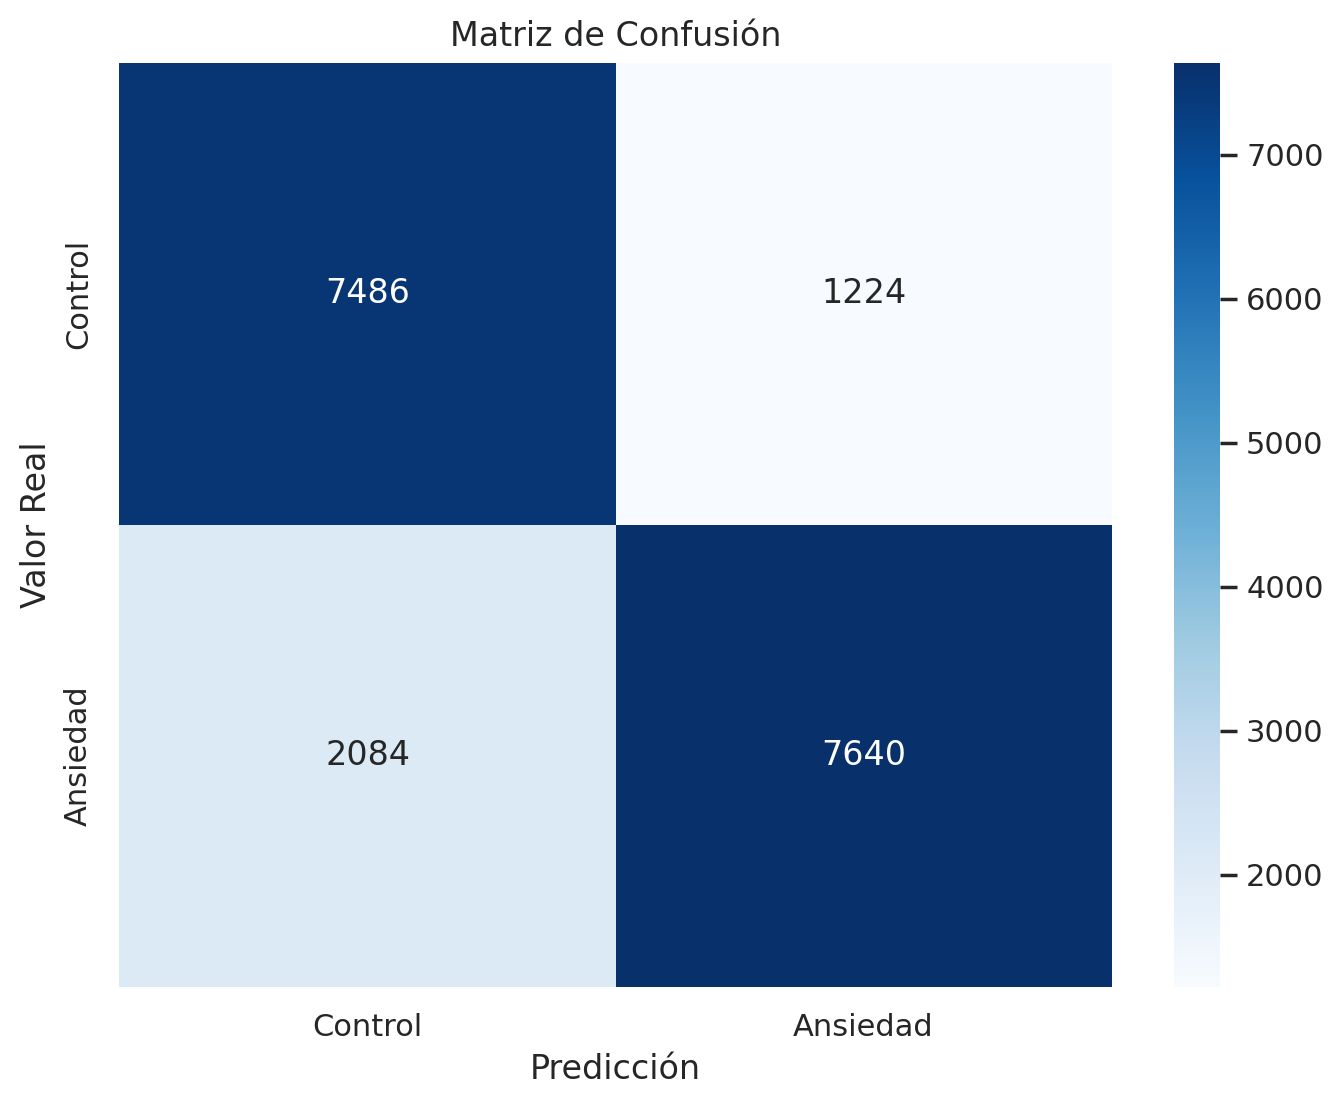

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# Aprensizaje del modelo: Red neuronal
**Validación Cruzada K=10**

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import LatentDirichletAllocation as LDA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Definir la estrategia de validación cruzada (k=10)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Listas para almacenar métricas de entrenamiento y validación
train_accuracy_scores = []
train_precision_scores = []
train_recall_scores = []
train_f1_scores = []

val_accuracy_scores = []
val_precision_scores = []
val_recall_scores = []
val_f1_scores = []

# Realizar la validación cruzada
for train_index, val_index in cv.split(X_train_lda, y_train):
    X_train_index, X_val_index = X_train_lda[train_index], X_train_lda[val_index]
    y_train_index, y_val_index = y_train[train_index], y_train[val_index]

    # Comprobar valores NaN en y_train_index
    nan_indices_train = np.isnan(y_train_index)
    if np.any(nan_indices_train):
        X_train_index = X_train_index[~nan_indices_train]
        y_train_index = y_train_index[~nan_indices_train]

    # Crear una red neuronal secuencial
    model = Sequential()

    # Agregar una capa de entrada con el número de características (tópicos) en tu matriz LDA
    model.add(Dense(128, activation='relu', input_dim=X_train_index.shape[1]))
    model.add(Dropout(0.1))  # Dropout para regularización

    # Agregar una capa oculta
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))  # Dropout para regularización

    # Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en los datos de entrenamiento
    model.fit(X_train_index, y_train_index, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = (model.predict(X_train_index) > 0.5).astype(int)

    # Calcular métricas de entrenamiento y agregarlas a las listas
    train_accuracy_scores.append(accuracy_score(y_train_index, y_train_pred))
    train_precision_scores.append(precision_score(y_train_index, y_train_pred))
    train_recall_scores.append(recall_score(y_train_index, y_train_pred))
    train_f1_scores.append(f1_score(y_train_index, y_train_pred))

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = (model.predict(X_val_index) > 0.5).astype(int)

    # Calcular métricas de validación y agregarlas a las listas
    val_accuracy_scores.append(accuracy_score(y_val_index, y_val_pred))
    val_precision_scores.append(precision_score(y_val_index, y_val_pred))
    val_recall_scores.append(recall_score(y_val_index, y_val_pred))
    val_f1_scores.append(f1_score(y_val_index, y_val_pred))

# Calcular las métricas promediadas en entrenamiento
train_accuracy_mean = np.mean(train_accuracy_scores)
train_precision_mean = np.mean(train_precision_scores)
train_recall_mean = np.mean(train_recall_scores)
train_f1_mean = np.mean(train_f1_scores)

# Imprimir las métricas en entrenamiento
print("Entrenamiento - Accuracy: {:.2f}%".format(100 * train_accuracy_mean))
print("Entrenamiento - Precision: {:.2f}%".format(100 * train_precision_mean))
print("Entrenamiento - Recall: {:.2f}%".format(100 * train_recall_mean))
print("Entrenamiento - F1 Score: {:.2f}%".format(100 * train_f1_mean))

# Calcular las métricas promediadas en validación
val_accuracy_mean = np.mean(val_accuracy_scores)
val_precision_mean = np.mean(val_precision_scores)
val_recall_mean = np.mean(val_recall_scores)
val_f1_mean = np.mean(val_f1_scores)

# Imprimir las métricas en validación
print("Validación - Accuracy: {:.2f}%".format(100 * val_accuracy_mean))
print("Validación - Precision: {:.2f}%".format(100 * val_precision_mean))
print("Validación - Recall: {:.2f}%".format(100 * val_recall_mean))
print("Validación - F1 Score: {:.2f}%".format(100 * val_f1_mean))

# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LDA/parametros /modelo_BoW_entrenado_LDA(k=10).h5')

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LDA/parametros /modelo_BoW_entrenado_LDA(k=10).h5')







135/135 [==============================] - 0s 1ms/step
Entrenamiento - Accuracy: 81.29%
Entrenamiento - Precision: 85.62%
Entrenamiento - Recall: 77.24%
Entrenamiento - F1 Score: 81.20%
Validación - Accuracy: 81.15%
Validación - Precision: 85.41%
Validación - Recall: 77.19%
Validación - F1 Score: 81.08%


In [ ]:
# Imprimir las métricas promediadas
print("Métricas de entrenamiento promediadas:")
print(f"Exactitud: {train_accuracy_mean * 100:.2f}%")
print(f"Precisión: {train_precision_mean * 100:.2f}%")
print(f"Recuperación: {train_recall_mean * 100:.2f}%")
print(f"Puntuación F1: {train_f1_mean * 100:.2f}%")

print("\nMétricas de validación promediadas:")
print(f"Exactitud: {val_accuracy_mean * 100:.2f}%")
print(f"Precisión: {val_precision_mean * 100:.2f}%")
print(f"Recuperación: {val_recall_mean * 100:.2f}%")
print(f"Puntuación F1: {val_f1_mean * 100:.2f}%")

Métricas de entrenamiento promediadas:
Exactitud: 81.29%
Precisión: 85.62%
Recuperación: 77.24%
Puntuación F1: 81.20%

Métricas de validación promediadas:
Exactitud: 81.15%
Precisión: 85.41%
Recuperación: 77.19%
Puntuación F1: 81.08%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val_index)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val_index, y_pred_binario)
prop_real = np.sum(y_val_index)/len(y_val_index)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val_index)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

769/769 [==============================] - 2s 3ms/step
Matriz de confusión: 

 [[8044 4450]
 [3881 8220]] 

Proporción de comentarios positivos: 0.49
Proporción de comentarios positivos etiquetados: 0.52


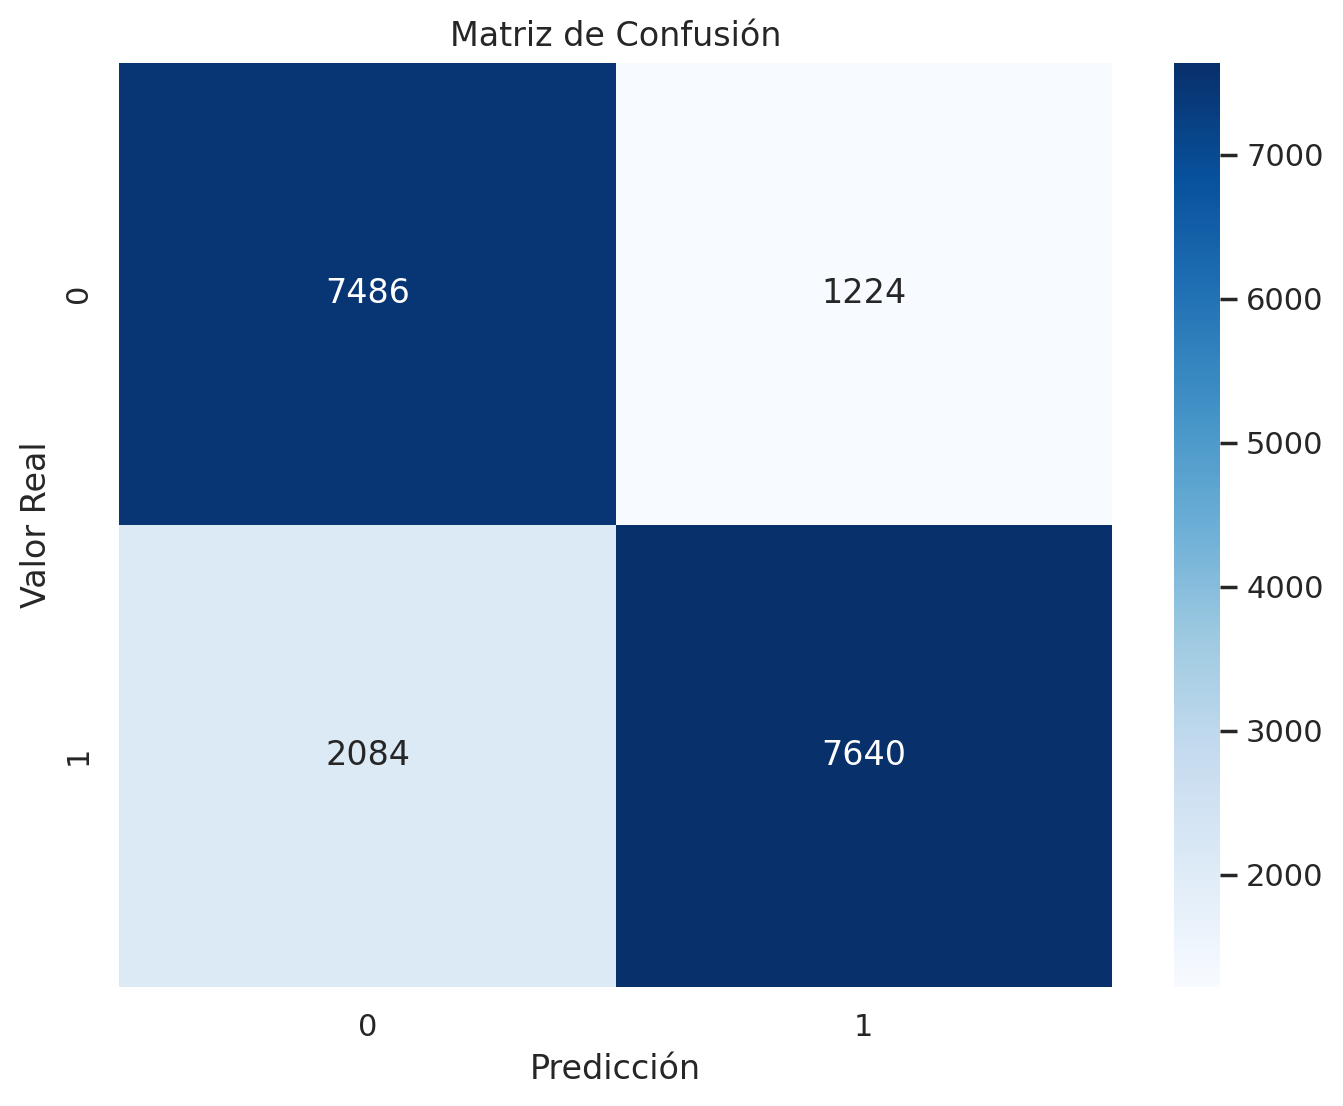

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# Guardar el modelo


In [ ]:
import joblib
import os
# Directorio para guardar modelos entrenados
model_dir = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LDA/parametros '
model_filename = 'TWEETS_ansiedad (RN-LDA).pkl'
model_path_p = os.path.join(model_dir, model_filename)

# Guardar el modelo entrenado
joblib.dump(model, model_path_p)

['/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Ansiedad /LDA/parametros /TWEETS_ansiedad (RN-LDA).pkl']